# EDA-Calidad del dataset Air_Quality

## Librerías

In [18]:
import os
import warnings

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Ajustes

Se ignoran los warnings.

In [20]:
warnings.filterwarnings("ignore")

Se hacen unas modificaciones en la configuracion para que los resultados salgan completos.

In [21]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)

## Importación del dataset

Ruta actual de este EDA-Calidad.

In [22]:
ruta_actual = os.getcwd()

ruta_actual

'c:\\Users\\franc\\Desktop\\taxi_electrico_nyc\\EDA'

Ruta raiz del proyecto.

In [23]:
ruta_del_proyecto = os.path.dirname(
    ruta_actual
    )

ruta_del_proyecto

'c:\\Users\\franc\\Desktop\\taxi_electrico_nyc'

Ruta del dataset 'Air_Quality'.

In [24]:
ruta_del_dataset = os.path.join(
    ruta_del_proyecto, 
    'assets', 
    'Datasets', 
    'Air_Quality_20241206.csv'
    )

ruta_del_dataset

'c:\\Users\\franc\\Desktop\\taxi_electrico_nyc\\assets\\Datasets\\Air_Quality_20241206.csv'

Se importa en dataset.

In [25]:
air_quality = pd.read_csv(
    ruta_del_dataset
    )

## Exploración General

Primeras cinco filas.

In [26]:
air_quality.head(5)

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value,Message
0,179772,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,409.0,Southeast Queens,2015,01/01/2015,0.3,NaN
1,179785,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,209.0,Bensonhurst - Bay Ridge,2015,01/01/2015,1.2,NaN
2,178540,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,209.0,Bensonhurst - Bay Ridge,Annual Average 2012,12/01/2011,8.6,NaN
3,178561,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,409.0,Southeast Queens,Annual Average 2012,12/01/2011,8.0,NaN
4,823217,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,409.0,Southeast Queens,Summer 2022,06/01/2022,6.1,NaN


Ultimas cinco filas.

In [27]:
air_quality.tail(5)

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value,Message
18020,816914,643,Annual vehicle miles traveled,Million miles,per square mile,CD,503.0,Tottenville and Great Kills (CD3),2019,01/01/2019,12.9,NaN
18021,816913,643,Annual vehicle miles traveled,Million miles,per square mile,CD,503.0,Tottenville and Great Kills (CD3),2010,01/01/2010,14.7,NaN
18022,816872,643,Annual vehicle miles traveled,Million miles,per square mile,UHF42,208.0,Canarsie - Flatlands,2010,01/01/2010,43.4,NaN
18023,816832,643,Annual vehicle miles traveled,Million miles,per square mile,UHF42,407.0,Southwest Queens,2010,01/01/2010,65.8,NaN
18024,151658,643,Annual vehicle miles traveled,Million miles,per square mile,UHF42,408.0,Jamaica,2005,01/01/2005,41.0,NaN


Tamaño.

In [28]:
print("Cantidad de filas: ")
print(air_quality.shape[0])
print()
print("Cantidad de columnas:")
print(air_quality.shape[1])

Cantidad de filas: 
18025

Cantidad de columnas:
12


## Tipos de datos

Se obtiene el nombre de cada columna y su tipo de dato.

In [29]:
air_quality.dtypes

Unique ID           int64
Indicator ID        int64
Name               object
Measure            object
Measure Info       object
Geo Type Name      object
Geo Join ID       float64
Geo Place Name     object
Time Period        object
Start_Date         object
Data Value        float64
Message           float64
dtype: object

## Valores Faltantes

Se seleccionan las columnas de tipo object.

In [30]:
columnas_object = air_quality.select_dtypes(include='object').columns

columnas_object

Index(['Name', 'Measure', 'Measure Info', 'Geo Type Name', 'Geo Place Name',
       'Time Period', 'Start_Date'],
      dtype='object')

Se comprueba si tienen cadenas vacias.

In [ ]:
filas_con_valores_vacios = air_quality[
    columnas_object].apply(lambda x: x == "").any(axis=1)

print('Cantidad de valores faltantes:')
print(filas_con_valores_vacios.sum())

Cantidad de valores faltantes:
0


## Valores Nulos

In [38]:
air_quality.isnull().sum()

Unique ID             0
Indicator ID          0
Name                  0
Measure               0
Measure Info          0
Geo Type Name         0
Geo Join ID           9
Geo Place Name        9
Time Period           0
Start_Date            0
Data Value            0
Message           18025
dtype: int64

Dos columnas tienen 9 valores nulos. La última columna, llamada Message, tiene todos sus valores nulos.

## Valores Duplicados

In [39]:
print(air_quality.duplicated().sum())

0


No hay ninguna fila duplicada.

Ayuda Memoria.

In [40]:
air_quality.dtypes

Unique ID           int64
Indicator ID        int64
Name               object
Measure            object
Measure Info       object
Geo Type Name      object
Geo Join ID       float64
Geo Place Name     object
Time Period        object
Start_Date         object
Data Value        float64
Message           float64
dtype: object

In [41]:
print(air_quality['Unique ID'].duplicated().sum())

0


No hay ningun valor repetido en la columna id llamada Unique ID.

## Diccionario de Datos

In [42]:
ruta_del_diccionario = os.path.join(
    ruta_del_proyecto, 
    'data', 
    'Data-Dictionary-Air_Quality_2024.xlsx'
    )

ruta_del_diccionario

'c:\\Users\\franc\\Desktop\\taxi_electrico_nyc\\data\\Data-Dictionary-Air_Quality_2024.xlsx'

In [43]:
diccionario = pd.read_excel(ruta_del_diccionario, sheet_name='Column Information', header=1)

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\franc\\Desktop\\taxi_electrico_nyc\\data\\Data-Dictionary-Air_Quality_2024.xlsx'

In [ ]:
diccionario

,Column Name,Column Description,Expected/Allowed Values,Field Limitations,Additional Notes
0,Name of the column exactly as it appears in the dataset.,"A brief, plain-language explanation of what the data in the column means.","Specifies if there is an expected range and/or format of possible values. For example, if the data type is Date & Time, this field will note whether the timestamp is MM/DD/YYYY or MM/YYYY. If the Column Name is ice cream, this field might note that values can be Chocolate, Vanilla or Strawberry.\n\nIf relevant, this field specifies the unit of measurement of the data field, e.g. thousands, millions, $ value, miles, feet, year, etc.","Describes any unique characteristics or potential analytical limitations presented by this field, including: \n- the reasoning for any null, zero, or empty values in the data\n- if the data in the column was integrated from another dataset or organization\n- if the data covered includes a different time period\n- the source of the column and how the data in the column was generated. \n\nFor example, information on how the data in this column was generated can include whether the data was self-reported directly by a person, system generated by a database or agency system, derived through analytical manipulation of other fields or records; or obtained from a different agency.",NaN
1,unique_id,Unique record identifier,NaN,NaN,NaN
2,indicator_id,Identifier of the type of measured value across time and space,NaN,"Indicators have the same data source, but may be broken into different measures",NaN
3,name,Name of the indicator,NaN,"Indicators have the same data source, but may be broken into different measures",NaN
4,measure,How the indicator is measured,NaN,This could indicate that data values are rates or counts or percentages - as well as if the measure is a stratification of the indicator data.,NaN
5,measure_info,Information (such as units) about the measure,NaN,NaN,NaN
6,geo_type_name,Geography type,UHF' stands for United Hospital Fund neighborhoods,"For instance, Citywide, Borough, and Community Districts are different geography types",NaN
7,geo_join_id,"Identifier of the neighborhood geographic area, used for joining to mapping geography files to make thematic maps",NaN,Reference the geo_type_name to know which geography files to join with,NaN
8,geo_place_name,Neighborhood name,NaN,Could be 'Brownsville' or 'Brooklyn' or other designation depending on Geography type,NaN
9,time_period,Description of the time that the data applies to,NaN,"Could be a year, range of years, or season for example",NaN


In [ ]:
diccionario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Column Name              13 non-null     object 
 1   Column Description       13 non-null     object 
 2   Expected/Allowed Values  2 non-null      object 
 3   Field Limitations        10 non-null     object 
 4   Additional Notes         0 non-null      float64
dtypes: float64(1), object(4)
memory usage: 652.0+ bytes


In [ ]:
diccionario.drop(columns='Additional Notes', inplace=True)

In [ ]:
diccionario

,Column Name,Column Description,Expected/Allowed Values,Field Limitations
0,Name of the column exactly as it appears in the dataset.,"A brief, plain-language explanation of what the data in the column means.","Specifies if there is an expected range and/or format of possible values. For example, if the data type is Date & Time, this field will note whether the timestamp is MM/DD/YYYY or MM/YYYY. If the Column Name is ice cream, this field might note that values can be Chocolate, Vanilla or Strawberry.\n\nIf relevant, this field specifies the unit of measurement of the data field, e.g. thousands, millions, $ value, miles, feet, year, etc.","Describes any unique characteristics or potential analytical limitations presented by this field, including: \n- the reasoning for any null, zero, or empty values in the data\n- if the data in the column was integrated from another dataset or organization\n- if the data covered includes a different time period\n- the source of the column and how the data in the column was generated. \n\nFor example, information on how the data in this column was generated can include whether the data was self-reported directly by a person, system generated by a database or agency system, derived through analytical manipulation of other fields or records; or obtained from a different agency."
1,unique_id,Unique record identifier,NaN,NaN
2,indicator_id,Identifier of the type of measured value across time and space,NaN,"Indicators have the same data source, but may be broken into different measures"
3,name,Name of the indicator,NaN,"Indicators have the same data source, but may be broken into different measures"
4,measure,How the indicator is measured,NaN,This could indicate that data values are rates or counts or percentages - as well as if the measure is a stratification of the indicator data.
5,measure_info,Information (such as units) about the measure,NaN,NaN
6,geo_type_name,Geography type,UHF' stands for United Hospital Fund neighborhoods,"For instance, Citywide, Borough, and Community Districts are different geography types"
7,geo_join_id,"Identifier of the neighborhood geographic area, used for joining to mapping geography files to make thematic maps",NaN,Reference the geo_type_name to know which geography files to join with
8,geo_place_name,Neighborhood name,NaN,Could be 'Brownsville' or 'Brooklyn' or other designation depending on Geography type
9,time_period,Description of the time that the data applies to,NaN,"Could be a year, range of years, or season for example"


## Outliers

### Columna 'Name'

Ayuda Memoria.

In [ ]:
air_quality.dtypes

Unique ID           int64
Indicator ID        int64
Name               object
Measure            object
Measure Info       object
Geo Type Name      object
Geo Join ID       float64
Geo Place Name     object
Time Period        object
Start_Date         object
Data Value        float64
Message           float64
dtype: object

Se obtienen los valores únicos de la columna 'Name'.

In [ ]:
air_quality['Name'].unique()

array(['Boiler Emissions- Total SO2 Emissions', 'Fine particles (PM 2.5)',
       'Nitrogen dioxide (NO2)',
       'Asthma emergency department visits due to PM2.5',
       'Annual vehicle miles traveled',
       'Respiratory hospitalizations due to PM2.5 (age 20+)',
       'Ozone (O3)', 'Asthma hospitalizations due to Ozone',
       'Boiler Emissions- Total NOx Emissions',
       'Boiler Emissions- Total PM2.5 Emissions',
       'Outdoor Air Toxics - Formaldehyde',
       'Asthma emergency departments visits due to Ozone',
       'Cardiovascular hospitalizations due to PM2.5 (age 40+)',
       'Cardiac and respiratory deaths due to Ozone',
       'Deaths due to PM2.5', 'Outdoor Air Toxics - Benzene',
       'Annual vehicle miles traveled (trucks)',
       'Annual vehicle miles traveled (cars)'], dtype=object)

In [ ]:
cantidad_de_valores_en_Name = air_quality['Name'].value_counts().reset_index()
cantidad_de_valores_en_Name.columns = ['Name', 'count']

cantidad_de_valores_en_Name

,Name,count
0,Fine particles (PM 2.5),5922
1,Nitrogen dioxide (NO2),5922
2,Ozone (O3),2115
3,Asthma emergency departments visits due to Ozone,485
4,Asthma hospitalizations due to Ozone,484
5,Asthma emergency department visits due to PM2.5,480
6,Annual vehicle miles traveled (cars),321
7,Annual vehicle miles traveled,321
8,Annual vehicle miles traveled (trucks),321
9,Deaths due to PM2.5,240


In [ ]:
Q1 = cantidad_de_valores_en_Name['count'].quantile(0.25)

outliers_categoricos = cantidad_de_valores_en_Name[cantidad_de_valores_en_Name['count'] < Q1]

print("Outliers categóricos detectados:")
outliers_categoricos

Outliers categóricos detectados:


,Name,count
13,Outdoor Air Toxics - Formaldehyde,203
14,Outdoor Air Toxics - Benzene,203
15,Boiler Emissions- Total SO2 Emissions,96
16,Boiler Emissions- Total PM2.5 Emissions,96
17,Boiler Emissions- Total NOx Emissions,96


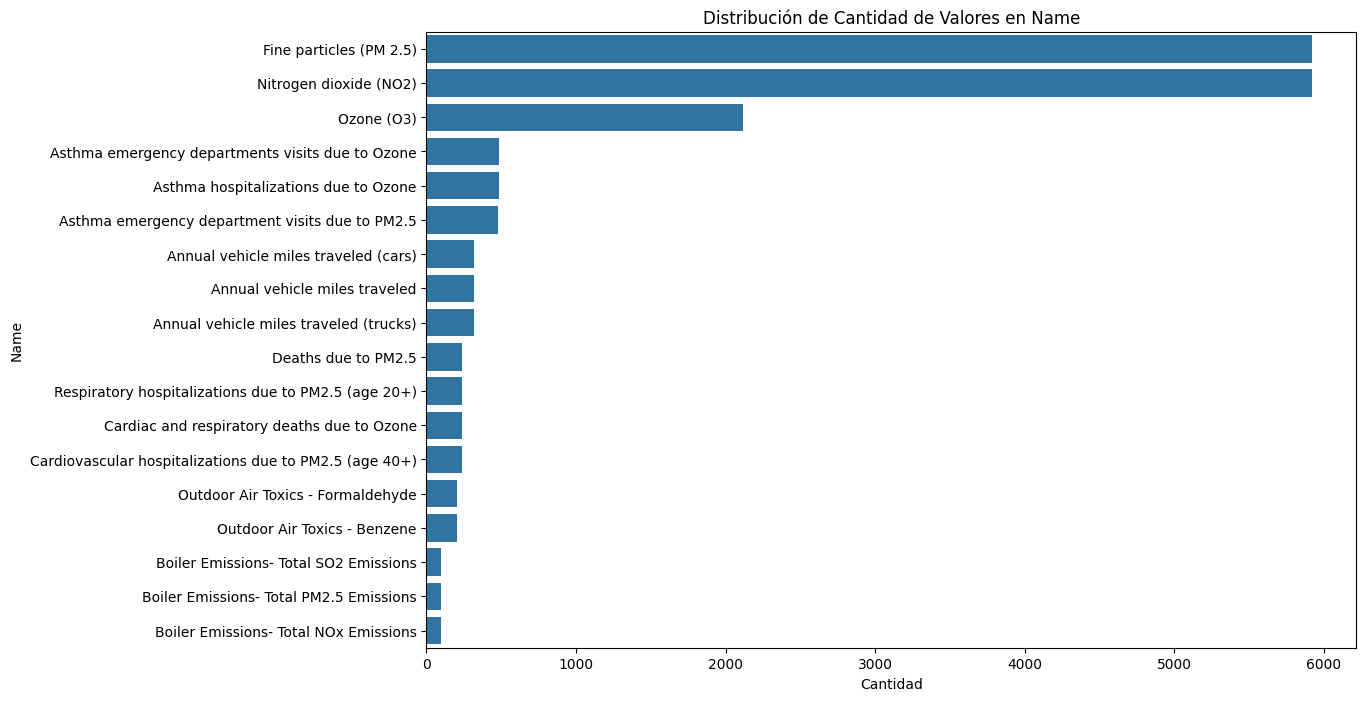

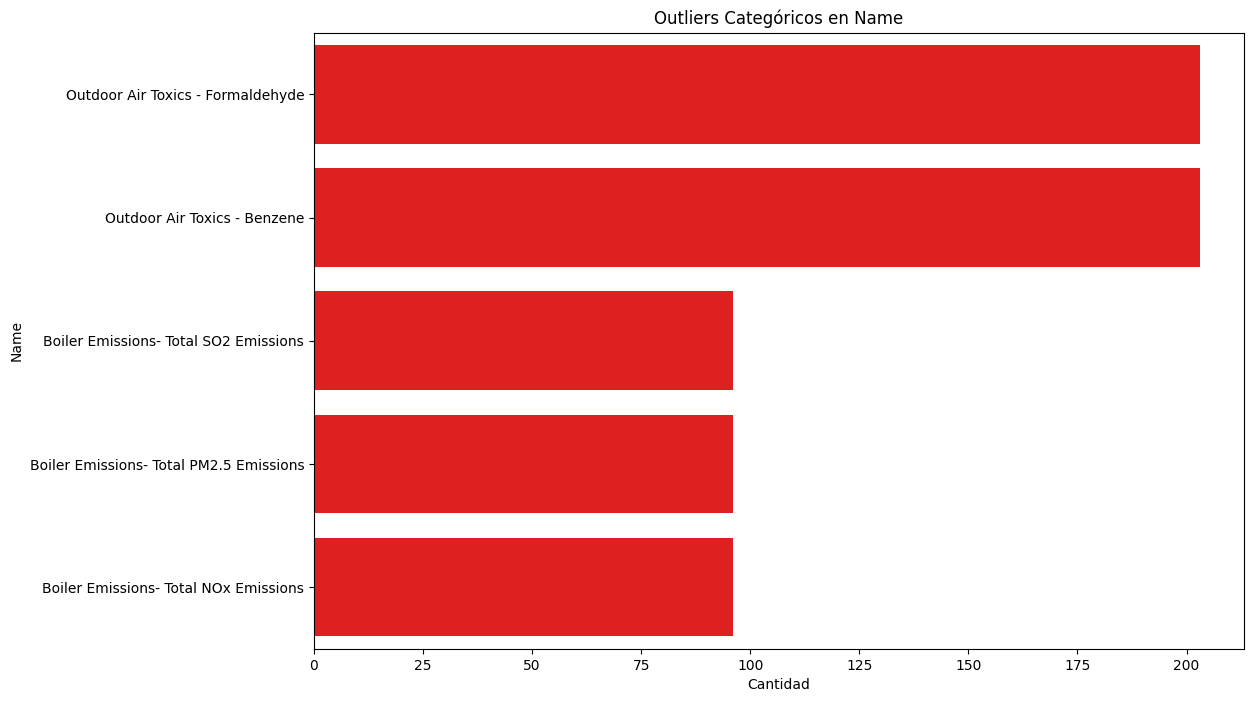

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(data=cantidad_de_valores_en_Name, x='count', y='Name')
plt.title('Distribución de Cantidad de Valores en Name')
plt.xlabel('Cantidad')
plt.ylabel('Name')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(data=outliers_categoricos, x='count', y='Name', color='red')
plt.title('Outliers Categóricos en Name')
plt.xlabel('Cantidad')
plt.ylabel('Name')
plt.show()

### Columna 'Measure'

Ayuda Memoria.

In [ ]:
air_quality.dtypes

Unique ID           int64
Indicator ID        int64
Name               object
Measure            object
Measure Info       object
Geo Type Name      object
Geo Join ID       float64
Geo Place Name     object
Time Period        object
Start_Date         object
Data Value        float64
Message           float64
dtype: object

In [ ]:
air_quality['Measure'].unique()

array(['Number per km2', 'Mean', 'Estimated annual rate (under age 18)',
       'Million miles', 'Estimated annual rate (age 18+)',
       'Estimated annual rate', 'Annual average concentration',
       'Estimated annual rate (age 30+)'], dtype=object)

In [ ]:
cantidad_de_valores_en_Measure = air_quality['Measure'].value_counts().reset_index()
cantidad_de_valores_en_Measure.columns = ['Measure', 'Count']

cantidad_de_valores_en_Measure

,Measure,Count
0,Mean,13959
1,Million miles,963
2,Estimated annual rate (under age 18),729
3,Estimated annual rate (age 18+),720
4,Estimated annual rate,720
5,Annual average concentration,406
6,Number per km2,288
7,Estimated annual rate (age 30+),240


In [ ]:
Q1 = cantidad_de_valores_en_Measure['Count'].quantile(0.25)

outliers_categoricos = cantidad_de_valores_en_Measure[cantidad_de_valores_en_Measure['Count'] < Q1]

print("Outliers categóricos detectados:")
outliers_categoricos

Outliers categóricos detectados:


,Measure,Count
6,Number per km2,288
7,Estimated annual rate (age 30+),240


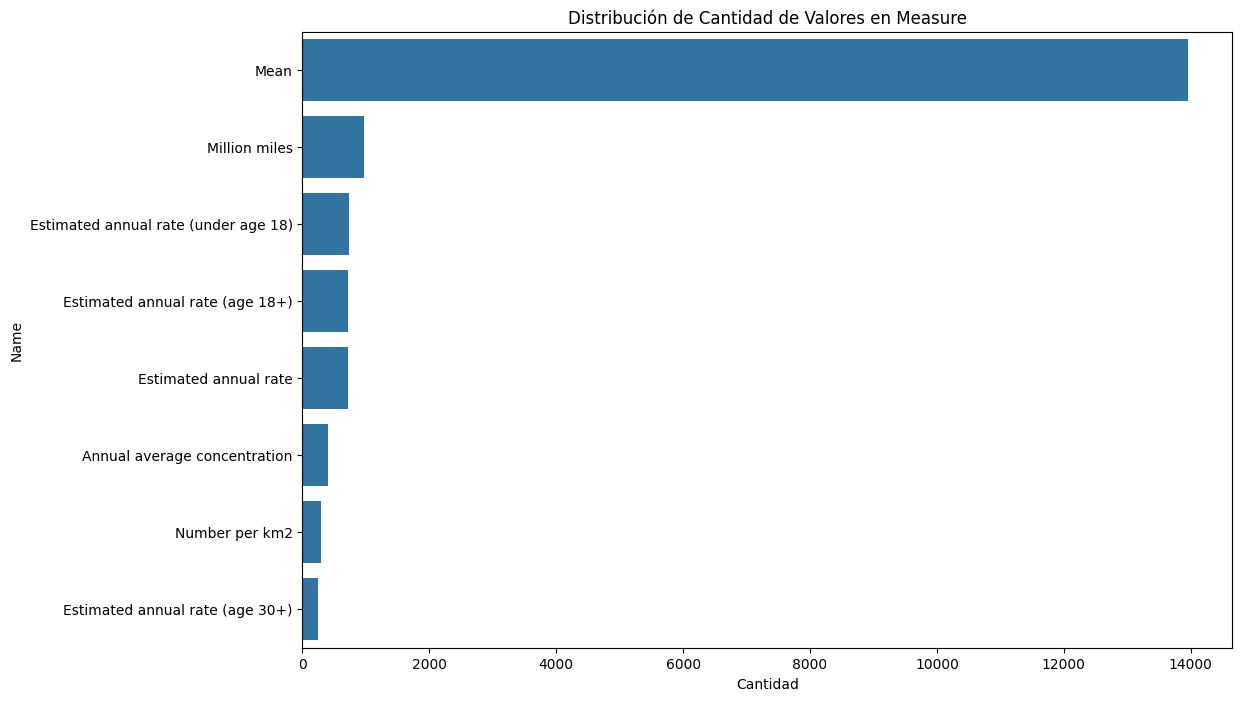

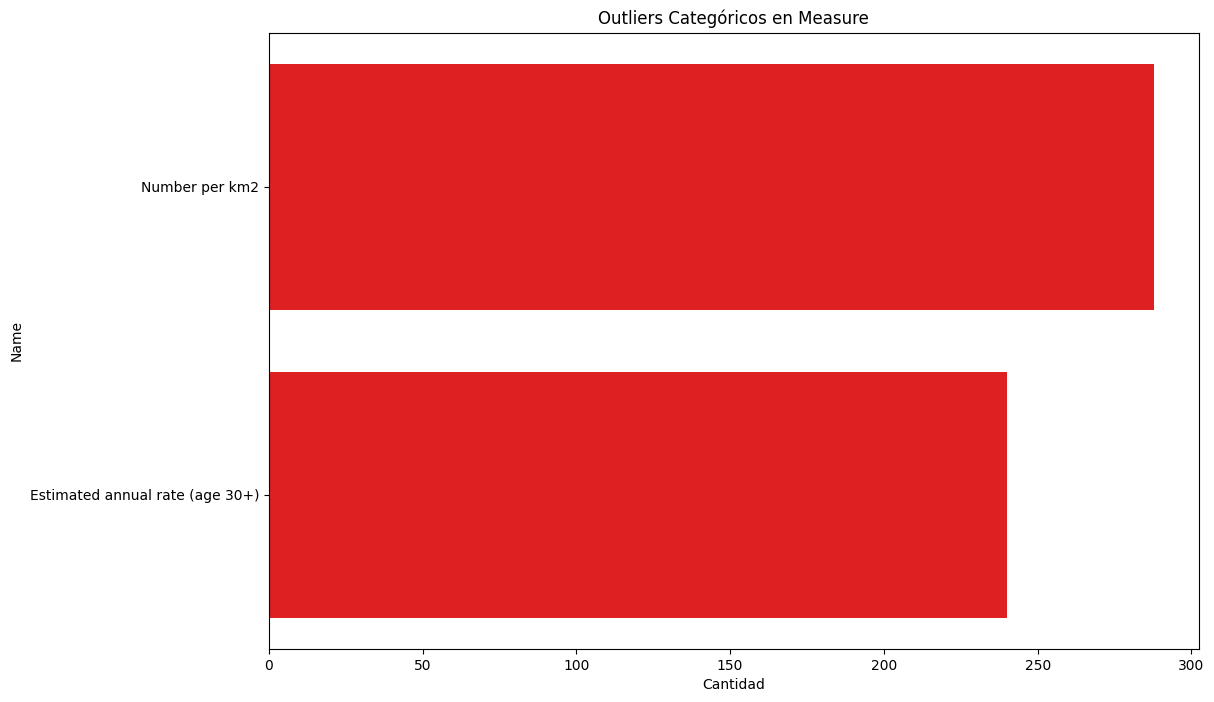

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(data=cantidad_de_valores_en_Measure, x='Count', y='Measure')
plt.title('Distribución de Cantidad de Valores en Measure')
plt.xlabel('Cantidad')
plt.ylabel('Name')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(data=outliers_categoricos, x='Count', y='Measure', color='red')
plt.title('Outliers Categóricos en Measure')
plt.xlabel('Cantidad')
plt.ylabel('Name')
plt.show()

### Columna 'Measure Info'

Ayuda Memoria

In [ ]:
air_quality.dtypes

Unique ID           int64
Indicator ID        int64
Name               object
Measure            object
Measure Info       object
Geo Type Name      object
Geo Join ID       float64
Geo Place Name     object
Time Period        object
Start_Date         object
Data Value        float64
Message           float64
dtype: object

In [ ]:
air_quality['Measure Info'].unique()

array(['number', 'mcg/m3', 'ppb', 'per 100,000 children',
       'per square mile', 'per 100,000 adults', 'Âµg/m3', 'per 100,000'],
      dtype=object)

In [ ]:
cantidad_de_valores_en_Measure_Info = air_quality['Measure Info'].value_counts().reset_index()
cantidad_de_valores_en_Measure_Info.columns = ['Measure Info', 'Count']

cantidad_de_valores_en_Measure_Info

,Measure Info,Count
0,ppb,8037
1,mcg/m3,5922
2,"per 100,000 adults",1440
3,per square mile,963
4,"per 100,000 children",729
5,Âµg/m3,406
6,number,288
7,"per 100,000",240


In [ ]:
Q1 = cantidad_de_valores_en_Measure_Info['Count'].quantile(0.25)

outliers_categoricos = cantidad_de_valores_en_Measure_Info[cantidad_de_valores_en_Measure_Info['Count'] < Q1]

print("Outliers categóricos detectados:")
outliers_categoricos

Outliers categóricos detectados:


,Measure Info,Count
6,number,288
7,"per 100,000",240


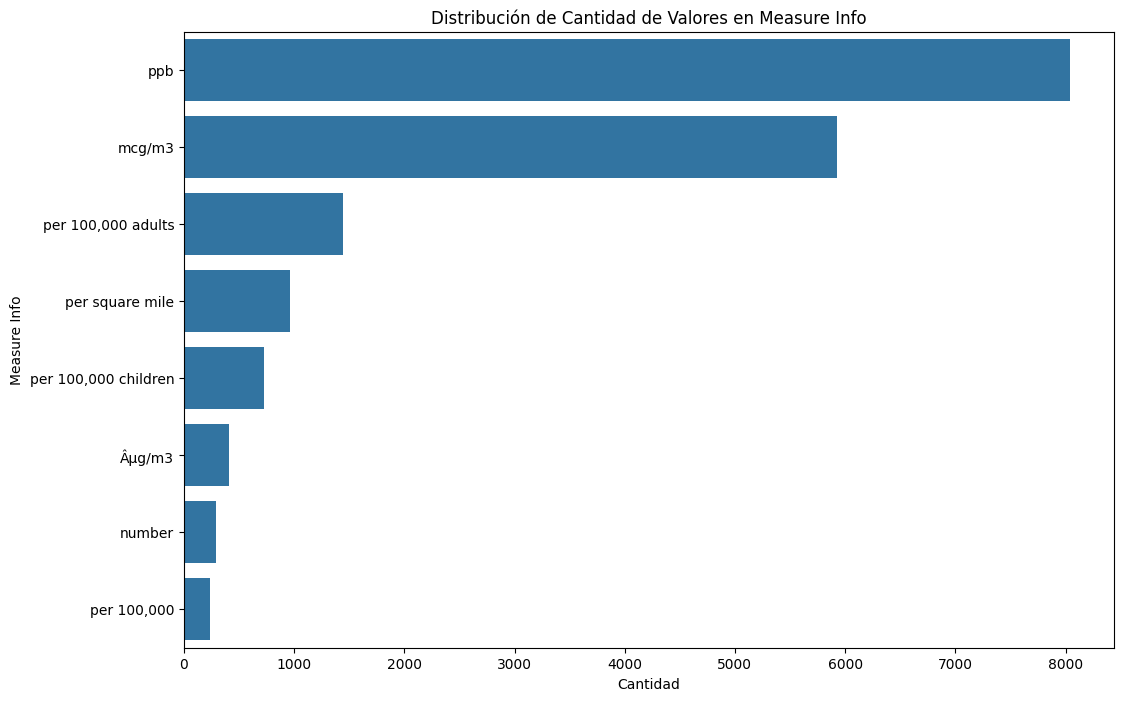

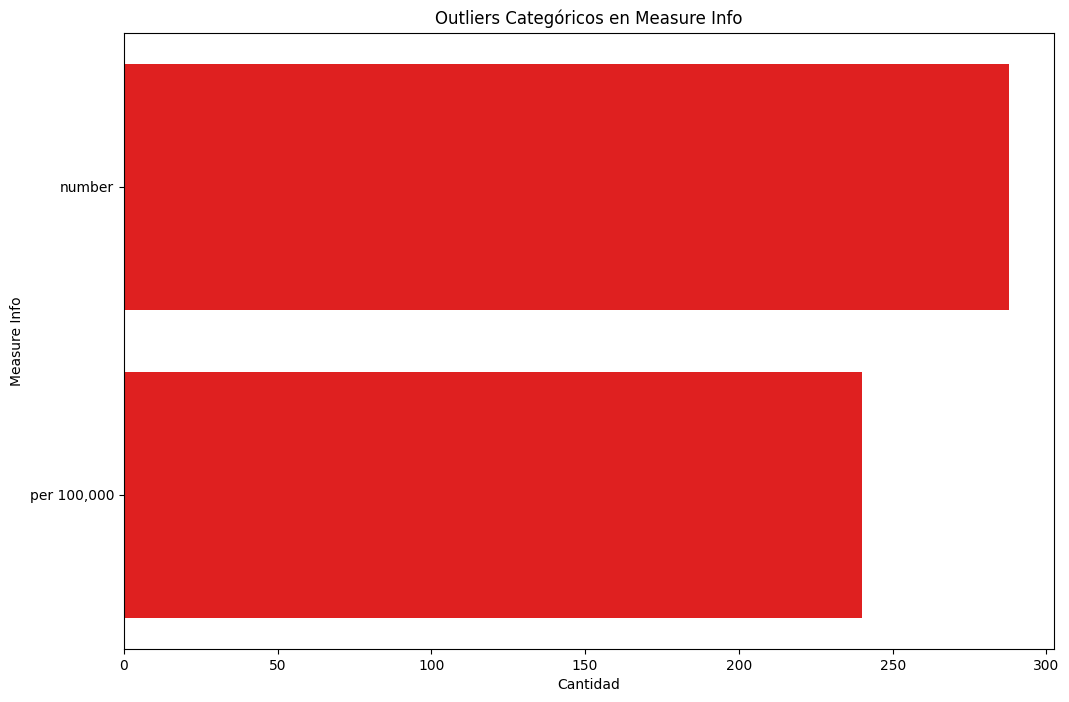

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(data=cantidad_de_valores_en_Measure_Info, x='Count', y='Measure Info')
plt.title('Distribución de Cantidad de Valores en Measure Info')
plt.xlabel('Cantidad')
plt.ylabel('Measure Info')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(data=outliers_categoricos, x='Count', y='Measure Info', color='red')
plt.title('Outliers Categóricos en Measure Info')
plt.xlabel('Cantidad')
plt.ylabel('Measure Info')
plt.show()

### Columna 'Geo Type Name'

Ayuda Memoria

In [ ]:
air_quality.dtypes

Unique ID           int64
Indicator ID        int64
Name               object
Measure            object
Measure Info       object
Geo Type Name      object
Geo Join ID       float64
Geo Place Name     object
Time Period        object
Start_Date         object
Data Value        float64
Message           float64
dtype: object

In [ ]:
air_quality['Geo Type Name'].unique()

array(['UHF42', 'UHF34', 'Borough', 'CD', 'Citywide'], dtype=object)

In [ ]:
cantidad_de_valores_en_Geo_Type_Name = air_quality['Geo Type Name'].value_counts().reset_index()
cantidad_de_valores_en_Geo_Type_Name.columns = ['Geo Type Name', 'Count']

cantidad_de_valores_en_Geo_Type_Name

,Geo Type Name,Count
0,UHF42,7140
1,CD,6490
2,UHF34,3366
3,Borough,859
4,Citywide,170


In [ ]:
Q1 = cantidad_de_valores_en_Geo_Type_Name['Count'].quantile(0.25)

outliers_categoricos = cantidad_de_valores_en_Geo_Type_Name[cantidad_de_valores_en_Geo_Type_Name['Count'] < Q1]

print("Outliers categóricos detectados:")
outliers_categoricos

Outliers categóricos detectados:


,Geo Type Name,Count
4,Citywide,170


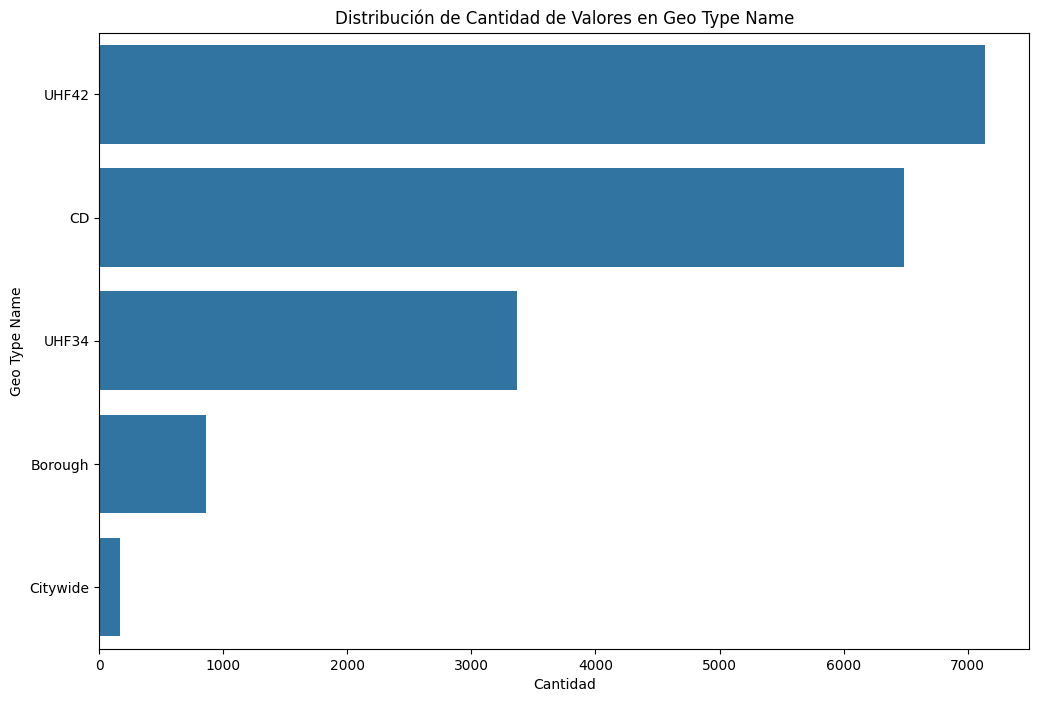

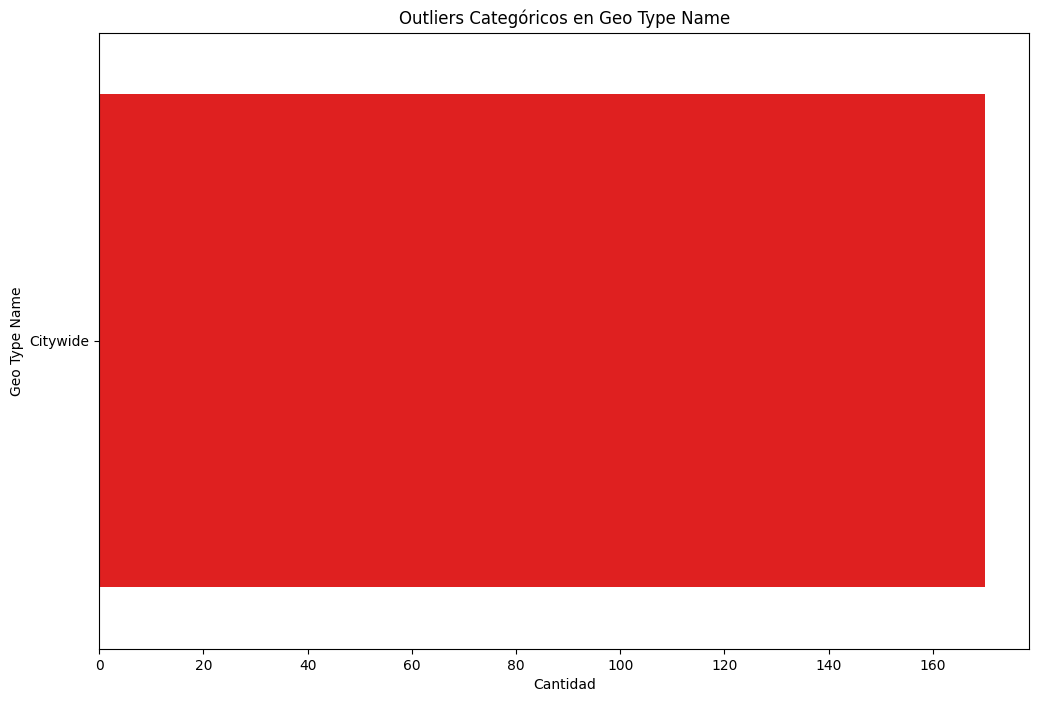

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(data=cantidad_de_valores_en_Geo_Type_Name, x='Count', y='Geo Type Name')
plt.title('Distribución de Cantidad de Valores en Geo Type Name')
plt.xlabel('Cantidad')
plt.ylabel('Geo Type Name')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(data=outliers_categoricos, x='Count', y='Geo Type Name', color='red')
plt.title('Outliers Categóricos en Geo Type Name')
plt.xlabel('Cantidad')
plt.ylabel('Geo Type Name')
plt.show()

### Columna 'Geo Place Name'

Ayuda Memoria

In [ ]:
air_quality.dtypes

Unique ID           int64
Indicator ID        int64
Name               object
Measure            object
Measure Info       object
Geo Type Name      object
Geo Join ID       float64
Geo Place Name     object
Time Period        object
Start_Date         object
Data Value        float64
Message           float64
dtype: object

In [ ]:
air_quality['Geo Place Name'].unique()

array(['Southeast Queens', 'Bensonhurst - Bay Ridge', 'Rockaways',
       'Coney Island - Sheepshead Bay', 'Williamsburg - Bushwick',
       'Bayside - Little Neck', 'Pelham - Throgs Neck', 'Upper West Side',
       'East New York', 'Canarsie - Flatlands', 'Jamaica',
       'Gramercy Park - Murray Hill', 'Hunts Point - Mott Haven',
       'Southwest Queens', 'Greenwich Village - SoHo', 'Brooklyn',
       'Downtown - Heights - Slope', 'Washington Heights',
       'Northeast Bronx', 'Greenpoint', 'Long Island City - Astoria',
       'Port Richmond', 'Kingsbridge - Riverdale',
       'Throgs Neck and Co-op City (CD10)',
       'Williamsbridge and Baychester (CD12)',
       'Jamaica and Hollis (CD12)',
       'South Ozone Park and Howard Beach (CD10)',
       'Kingsbridge Heights and Bedford (CD7)', 'Sunset Park (CD7)',
       'Rockaway and Broad Channel (CD14)', 'Upper West Side (CD7)',
       'Flushing and Whitestone (CD7)', 'Bushwick (CD4)',
       'Bedford Stuyvesant (CD3)', 'Jackson H

In [ ]:
cantidad_de_valores_en_Geo_Place_Name = air_quality['Geo Place Name'].value_counts().reset_index()
cantidad_de_valores_en_Geo_Place_Name.columns = ['Geo Place Name', 'Count']

cantidad_de_valores_en_Geo_Place_Name

,Geo Place Name,Count
0,Southeast Queens,269
1,Bensonhurst - Bay Ridge,269
2,Rockaways,269
3,Coney Island - Sheepshead Bay,269
4,Williamsburg - Bushwick,269
5,Pelham - Throgs Neck,269
6,East New York,269
7,Upper West Side,269
8,Canarsie - Flatlands,269
9,Jamaica,269


In [ ]:
Q1 = cantidad_de_valores_en_Geo_Place_Name['Count'].quantile(0.25)

outliers_categoricos = cantidad_de_valores_en_Geo_Place_Name[cantidad_de_valores_en_Geo_Place_Name['Count'] < Q1]

print("Outliers categóricos detectados:")
outliers_categoricos

Outliers categóricos detectados:


,Geo Place Name,Count
107,Northern SI,99
108,Southern SI,99
109,Bayside Little Neck-Fresh Meadows,99
110,South Bronx,99
111,Upper East Side-Gramercy,99
112,Chelsea-Village,99
113,Union Square-Lower Manhattan,99


No se va crear graficos para esta columna porque son demasiados valores.

Se van a obtener la cantidad de vecindarios por las cantidades.

In [ ]:
cantidad_de_valores_en_Geo_Place_Name.groupby('Count').agg('count')

,Geo Place Name
Count,
99,7
110,59
170,21
269,27


### Columna 'Data Value'

Ayuda Memoria

In [ ]:
air_quality.dtypes

Unique ID           int64
Indicator ID        int64
Name               object
Measure            object
Measure Info       object
Geo Type Name      object
Geo Join ID       float64
Geo Place Name     object
Time Period        object
Start_Date         object
Data Value        float64
Message           float64
dtype: object

In [ ]:
air_quality['Data Value'].describe()

count    18025.000000
mean        21.428616
std         23.999345
min          0.000000
25%          8.900000
50%         15.200000
75%         26.700000
max        424.700000
Name: Data Value, dtype: float64

In [ ]:
cantidad_de_valores_en_Data_Value = air_quality['Data Value'].value_counts()

cantidad_de_valores_en_Data_Value

Data Value
8.3      144
8.0      140
10.0     136
8.4      134
6.7      133
8.2      133
8.1      132
10.4     128
9.9      128
8.9      127
7.4      125
8.6      125
7.9      124
8.5      122
9.0      122
9.1      120
7.0      120
9.8      119
8.7      118
10.2     114
7.8      114
7.2      114
7.3      111
10.1     110
9.2      109
11.0     107
9.5      107
10.3     107
8.8      105
7.5      104
7.1      103
6.6      101
7.7       95
9.7       94
9.3       93
6.5       92
11.1      91
11.4      89
10.6      89
7.6       89
9.6       88
11.7      88
10.5      88
6.8       88
6.9       86
11.5      85
10.8      85
9.4       84
6.4       84
11.6      79
6.3       77
6.0       76
12.1      74
13.0      73
10.7      69
13.1      68
6.2       67
10.9      66
11.8      65
12.0      65
14.3      64
6.1       63
19.0      59
21.3      59
25.9      59
2.0       59
11.3      58
26.9      58
14.2      58
30.3      57
14.0      57
16.0      56
29.7      56
25.3      56
12.8      55
12.6      55
3

In [ ]:
df_cantidad = cantidad_de_valores_en_Data_Value.reset_index()
df_cantidad.columns = ['Data Value', 'Count']

Q1 = df_cantidad['Count'].quantile(0.25)
print('Primer cuartil:')
print(Q1)

print('Mediana')
print(df_cantidad['Count'].median())


Q3 = df_cantidad['Count'].quantile(0.75)
print('Tercer cuartil:')
print(Q3)

IQR = Q3 - Q1
print('IQR:')
print(IQR)

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_cantidad[(df_cantidad['Count'] < lower_bound) | (df_cantidad['Count'] > upper_bound)]

print('Limite Inferior')
print(lower_bound)

print('Limite Superior')
print(upper_bound)

print("Cinco Outliers mas importantes detectados:")
outliers.head()

Primer cuartil:
1.0
Mediana
2.0
Tercer cuartil:
26.0
IQR:
25.0
Limite Inferior
-36.5
Limite Superior
63.5
Cinco Outliers mas importantes detectados:


,Data Value,Count
0,8.3,144
1,8.0,140
2,10.0,136
3,8.4,134
4,6.7,133


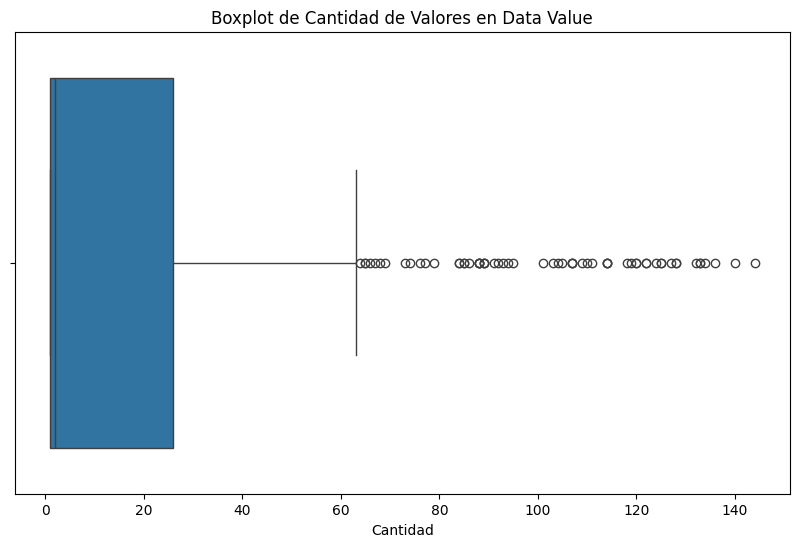

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_cantidad['Count'])
plt.title('Boxplot de Cantidad de Valores en Data Value')
plt.xlabel('Cantidad')
plt.show()

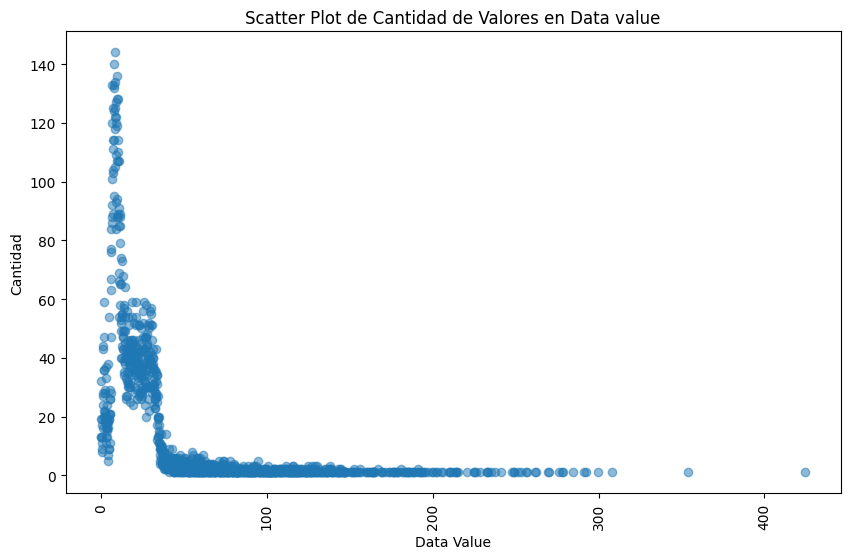

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_cantidad['Data Value'], df_cantidad['Count'], alpha=0.5)
plt.xlabel('Data Value')
plt.ylabel('Cantidad')
plt.title('Scatter Plot de Cantidad de Valores en Data value')
plt.xticks(rotation=90)  # Rotar etiquetas para mejor lectura
plt.show()
